# 计算机视觉课程作业
以下任务均在当前image-classifier.ipynb中执行，需要完整执行所有代码，并保存输出结果。完成任务后提交image-classifier.ipynb文件。
### 任务一：提升模型预测准确率
以下代码已经实现了基本的CIFAR-10图像分类。   
在不使用其他预训练模型下（即只能在CIFAR-10数据上从头训练模型），请通过数据增强、模型结构优化、更改优化策略（优化器，epoch，损失函数等）等方式提升模型预测准确率。   
<font color=red>注意：成绩会通过“Step 5: Evaluate model accuracy”的输出结果Average Acc进行评分，请勿更改step 5的代码，且需要完整执行所有代码。</font>

### 任务二：T-SNE
使用pytorch中的hook提取测试集“testloader”在模型中间层的特征表示，并使用T-SNE方法进行可视化。   
<font color=red>注意：可视化结果应当作为"Step 6: T-SNE Visualization"的输出结果。</font>

# 任务一：提升模型预测准确率

## Step 1: Download a dataset and preview images

A model is only as good as its dataset.

Training tools need lots of high-quality data to build accurate models. We'll use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 60,000 photos to build our image classifier. Get started by downloading the dataset with `torchvision` and previewing a handful of images from it.

Files already downloaded and verified
Files already downloaded and verified


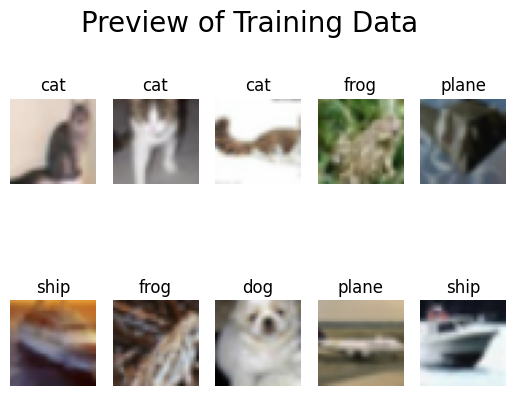

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Download the CIFAR-10 dataset to ./data
batch_size=10
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(24),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize(32),
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Our model will recognize these kinds of objects
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Grab images from our training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    plt.title(classes[labels[i]])

plt.suptitle('Preview of Training Data', size=20)
plt.show()

# Step 2: Configure the neural network

Now that we have our dataset, we need to set up a neural network for PyTorch. Our neural network will transform an image into a description.

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ResBlock(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.conv1 = nn.Conv2d(channel, channel, 3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(channel)
    def forward(self, x):
        return F.relu(self.norm1(x + self.conv1(x)))
    def __call__(self, x):
        return self.forward(x)


# Define a convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.structure = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            # self.norm1 = nn.BatchNorm2d(9)
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 256),
            nn.Linear(256, 64),
            nn.Linear(64, 10),
            
        )
    def forward(self, x):
        return self.structure(x)
net = Net()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

print("Your network is ready for training!")
print(net.state_dict())

Your network is ready for training!
OrderedDict([('structure.0.weight', tensor([[[[ 0.0027,  0.1627, -0.0035],
          [-0.1730, -0.0416, -0.1632],
          [-0.1656,  0.1197,  0.1095]],

         [[ 0.1279,  0.0255,  0.0663],
          [ 0.0893, -0.0867,  0.1808],
          [ 0.1613,  0.0966,  0.1364]],

         [[ 0.0311, -0.1538,  0.1323],
          [ 0.0641,  0.1750, -0.0274],
          [ 0.1270,  0.0148, -0.1372]]],


        [[[-0.0555,  0.1550,  0.0861],
          [ 0.1060,  0.0738,  0.0785],
          [-0.1724, -0.0467,  0.0010]],

         [[-0.1274,  0.1387,  0.0934],
          [ 0.1531,  0.1225,  0.0960],
          [ 0.0783,  0.1458, -0.0269]],

         [[ 0.0189,  0.1402,  0.1280],
          [-0.0120,  0.0202, -0.0395],
          [-0.0369, -0.1041,  0.1274]]],


        [[[-0.1634, -0.1094,  0.0677],
          [-0.0360, -0.0283,  0.0115],
          [-0.0683,  0.0767,  0.1129]],

         [[-0.0561,  0.0862, -0.0460],
          [ 0.1633,  0.1767,  0.1863],
          [-0

# Step 3: Train the network and save model

PyTorch trains our network by adjusting its parameters and evaluating its performance against our labelled dataset.

In [5]:
from tqdm import tqdm
import os

EPOCHS = 2
PATH = './cifar_net.pth'
print("Training...")
if(os.path.exists(PATH)):
    net.load_state_dict(torch.load(PATH))
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Save our trained model
torch.save(net.state_dict(), PATH)

Training...


Epoch 1 of 2:  13%|███▍                      | 669/5000 [02:36<16:52,  4.28it/s]


KeyboardInterrupt: 

# Step 4: Test the trained model

Let's test our model!

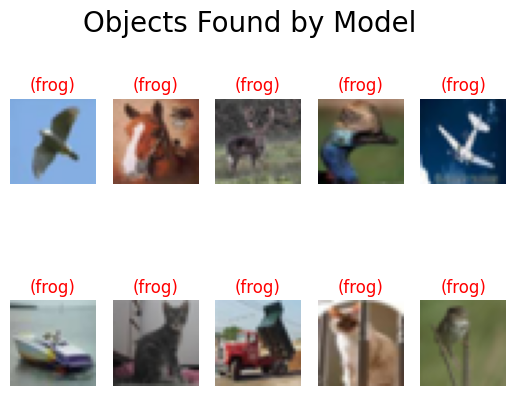

In [ ]:
# Pick random photos from training set
if dataiter == None:
    dataiter = iter(testloader)
images, labels = dataiter.next()

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

# Step 5: Evaluate model accuracy

Let's conclude by evaluating our model's overall performance.

In [ ]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
average_accuray = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    average_accuray.append(accuracy)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
print ('Average Acc:', np.mean(average_accuray))

Accuracy for class: plane is 64.0 %
Accuracy for class: car   is 62.5 %
Accuracy for class: bird  is 17.9 %
Accuracy for class: cat   is 4.0 %
Accuracy for class: deer  is 30.4 %
Accuracy for class: dog   is 63.0 %
Accuracy for class: frog  is 77.2 %
Accuracy for class: horse is 52.1 %
Accuracy for class: ship  is 59.0 %
Accuracy for class: truck is 60.5 %
Average Acc: 49.06


# 任务二：T-SNE

# Step 6: T-SNE Visualization

Visualize high-dimensional data in a low-dimensional space using T-SNE.